Online Retail K-Means & Hierarchical Clustering

Source : https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering?resource=download

Pada notebook yang saya gunakan sebagai referensi, project ini mengambil dataset dari transaksi penjualan sebuah online retail di Inggris.
Tujuan dari pengolahan dataset ini adalah untuk menemukan kelompok pelanggan agar perusahaan dapat menargetkan customernya secara efisien.


Segmentasi yang dilakukan berdasar pada analisis segmentasi pelanggan dengan model RFM yaitu Recency, Frequency dan Monetary. Monetary disini dilambangkan oleh atribut Amount.

Step yang dilakukan ada 5 yaitu

1. Reading and Understanding Data
2. Data Cleaning
3. Data Preparation 
4. Model Building 
5. Final Analysis

# Reading and Understanding Data


In [ ]:
# pertama dilakukan inmport mengenai libraries-libraries yang dibutuhkan dalam pengerjaan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


# dibawah merupakan libraries yang diperlukan untuk clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
# import dataset yang diperlukan
# dataset merupakan data dari transaksi online

from google.colab import files
uploaded = files.upload()

Saving OnlineRetail.csv to OnlineRetail (1).csv


In [ ]:
# membaca dataset

retail = pd.read_csv("OnlineRetail.csv", sep=",", encoding="ISO-8859-1", header=0)

In [ ]:
# deskripsi teratas untuk dataset berupa kategori dan isinya

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
# menghitung total elemen di dataset

retail.shape

(541909, 8)

In [ ]:
# info mengenai kolom dari dataset 

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# deskripsi perhitungan dari dataset

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


# Data Cleaning

In [ ]:
# menghitung banyak nilai yang hilang di dataset

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [ ]:
# menghilangkan baris yang memiliki nilai null dengan drop

retail = retail.dropna()
retail.shape

(406829, 8)

In [ ]:
# mengubah kolom 'CustomerID' dari tipe int ke tipe  string

retail['CustomerID'] = retail['CustomerID'].astype(str)

# Data Preparation

In [ ]:
# Merupakan pengelompokan atribut baru berupa monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
# Pengelompokan atribut baru berupa Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
# Penggabungan 2 kolom Amount dan Frequency

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
# Atribut baru yaitu Recency
# Diambil dari kolom 'InvoiceDate' lalu diubah datatype-nya agar dapat di olah

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [ ]:
# Penghitungan tanggal maksimal untuk mengetahui tanggal transaksi terakhir

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [ ]:
# Atribut baru untuk menampung penghitungan dari max date dengan transaction date untuk mencari perbedaannya

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [ ]:
# Penghitungan atribut recency dengan perbedaan tanggal untuk mengetahui pelanggan baru

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
# Pengambilan data hanya berupa hari saja

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [ ]:
# Penggabungan kolom Amount, Frequency dan Recency untuk mendapatkan dataframe RFM

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

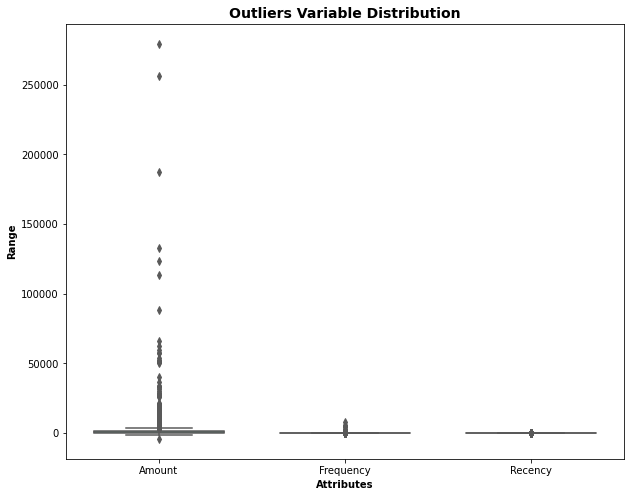

In [ ]:
# Analisis Outlier dari kolom Amount, Recency dan Frequency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Penghapusan stastitical outlier dari kolom Amount, Recency dan Frequency

Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [ ]:
# Melakukan rescaling dari 3 atribut

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Contoh dari scaling
scaler = StandardScaler()

# Setelah melakukan StandarScaler maka dilakukan fit_transform untuk menemukan datapoint dari feature F dari kalkulasi mean dan standar deviasi
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [ ]:
# Hasil akhir dari scaling 3 atribut

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188



# Building the Model

In [ ]:
# Penginisialisasian k-means untuk mendapatkan k point

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [ ]:
kmeans.labels_

array([2, 0, 1, ..., 2, 1, 1], dtype=int32)

Setelah itu kita mencari angka optimal untuk pengclusteran. Dalam unsuoervised algorithm, langkah utama yang diperlukan adalah pencarian angka optimal dalam melakukan cluster. Kita akan menggunakan metode elbow curves untuk mendapatkan angka yang tepat.



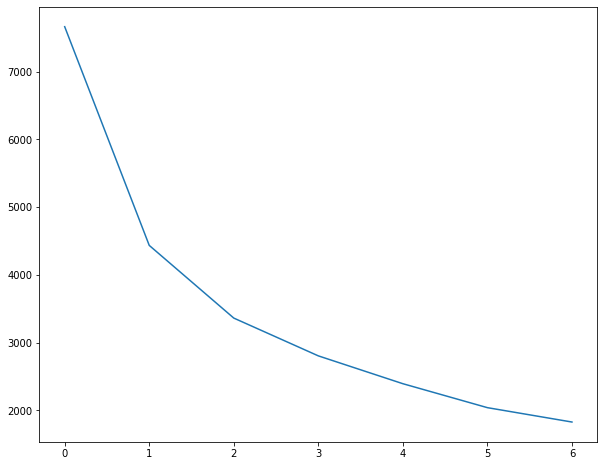

In [ ]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)

 # plot SSD untuk setiap n_cluster   
plt.plot(ssd)

Silhouette Analysis

silhouette score = p−q/max(p,q)
 
p  adalah jarak rata-rata ke titik-titik dalam cluster terdekat yang titik datanya bukan merupakan bagian dari

q  adalah jarak intra-cluster rata-rata ke semua titik dalam clusternya sendiri.

- Nilai rentang skor siluet terletak antara -1 sampai 1.

- Skor yang mendekati 1 menunjukkan bahwa titik data sangat mirip dengan titik data lain dalam cluster,

- Skor yang mendekati -1 menunjukkan bahwa titik data tidak serupa dengan titik data dalam clusternya.

In [ ]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # inisialisasi kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.48185520134959714
For n_clusters=5, the silhouette score is 0.46532456623494595
For n_clusters=6, the silhouette score is 0.4175495621530355
For n_clusters=7, the silhouette score is 0.41511487119884277
For n_clusters=8, the silhouette score is 0.41189609853935183


In [ ]:
# Final model with k=3

kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [ ]:
 kmeans.labels_

array([0, 1, 2, ..., 0, 2, 2], dtype=int32)

In [ ]:
# Pelabelan

rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0


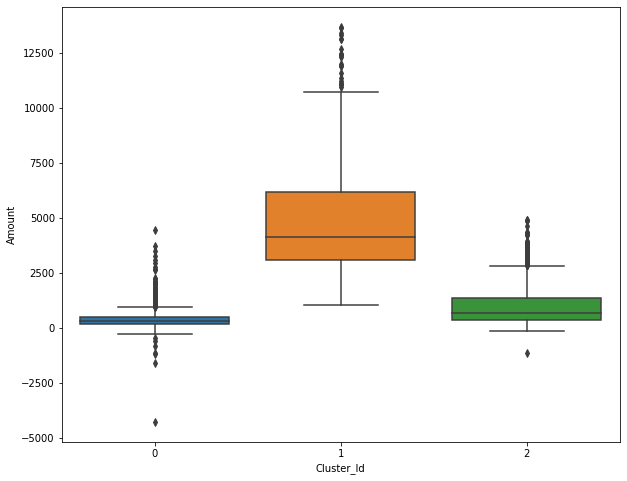

In [ ]:
# Visualisasi Cluster_Id vs Amount dengan boxplot

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

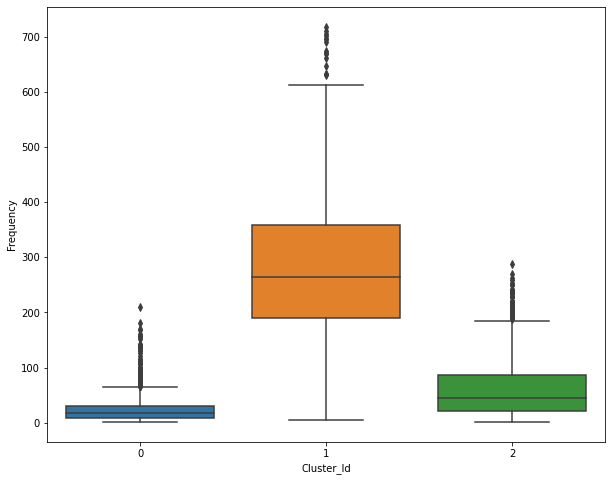

In [ ]:
# Visualisasi Cluster_Id vs Frequency dengan boxplot

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

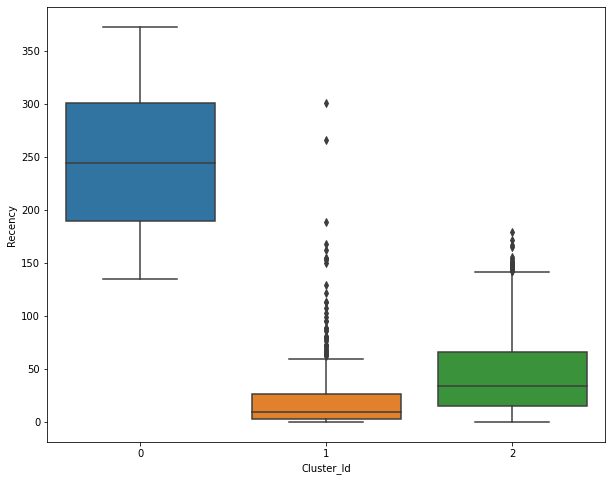

In [ ]:
# Visualisasi Cluster_Id vs Recency dengan boxplot

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

Dibawah ini merupakan proses hiearchical clustering

Pengelompokan hierarki melibatkan pembuatan cluster yang memiliki urutan yang telah ditentukan dari atas ke bawah. Misalnya, semua file dan folder di hard disk diatur dalam hierarki. 

Ada dua jenis pengelompokan hierarkis,

1. Divisive
2. Agglomerative.

Single Linkage

Dalam pengelompokan hierarki single linkage, jarak antara dua cluster didefinisikan sebagai jarak terpendek antara dua titik di setiap cluster. Misalnya, jarak antara cluster "r" dan "s" ke kiri sama dengan panjang panah antara dua titik terdekatnya.

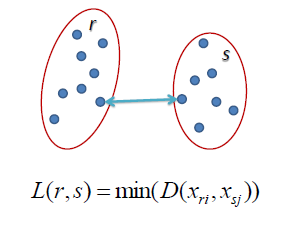

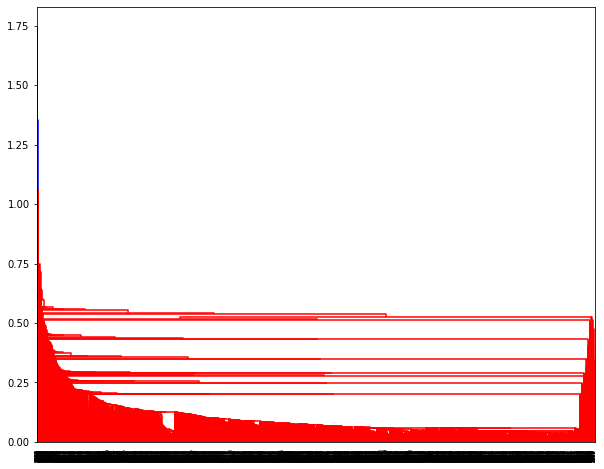

In [ ]:
# Single linkage: 

mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

Complete Linkage

Dalam pengelompokan hierarki complete linkage, jarak antara dua cluster didefinisikan sebagai jarak terpanjang antara dua titik di setiap cluster. Misalnya, jarak antara cluster "r" dan "s" ke kiri sama dengan panjang panah antara dua titik terjauhnya.

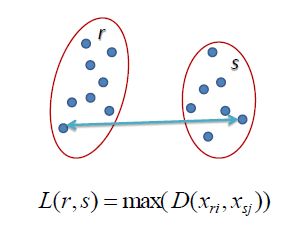

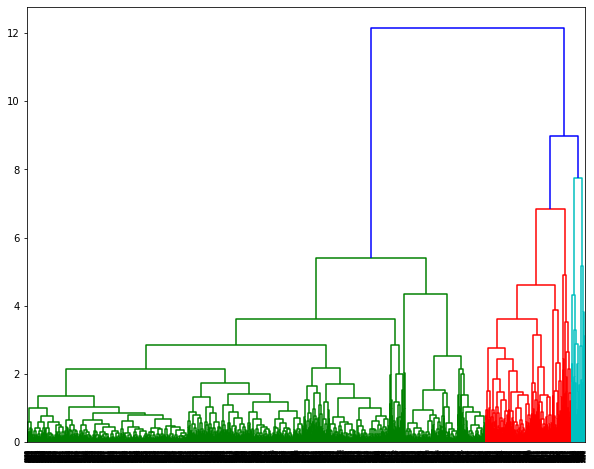

In [ ]:
# Complete linkage

mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Average Linkage:

Dalam pengelompokan hierarki average linkage, jarak antara dua cluster didefinisikan sebagai jarak rata-rata antara setiap titik dalam satu cluster ke setiap titik di cluster lainnya. Misalnya, jarak antara cluster "r" dan "s" ke kiri sama dengan panjang rata-rata setiap panah antara menghubungkan titik-titik satu cluster ke cluster lainnya.

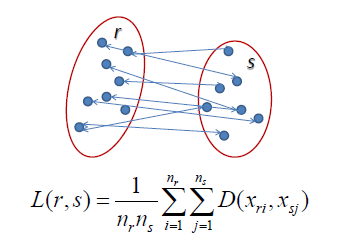

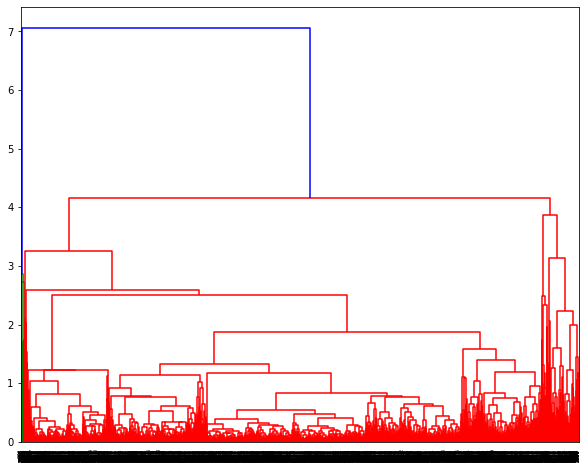

In [ ]:
# Average linkage:

mergings = linkage(rfm_df_scaled, method="average", metric='euclidean')
dendrogram(mergings)
plt.show()

Cutting the Dendrogram based on K

In [ ]:
# 3 clusters

cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Menetapkan label pada kluster

rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id,Cluster_Labels
0,12346.0,0.00,2,325,0,0
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,2,0
3,12349.0,1757.55,73,18,2,0
4,12350.0,334.40,17,309,0,0


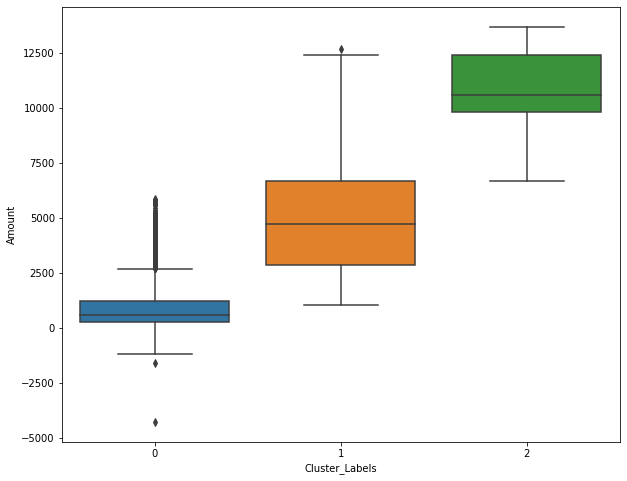

In [ ]:
# Plot Cluster Id vs Amount

sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

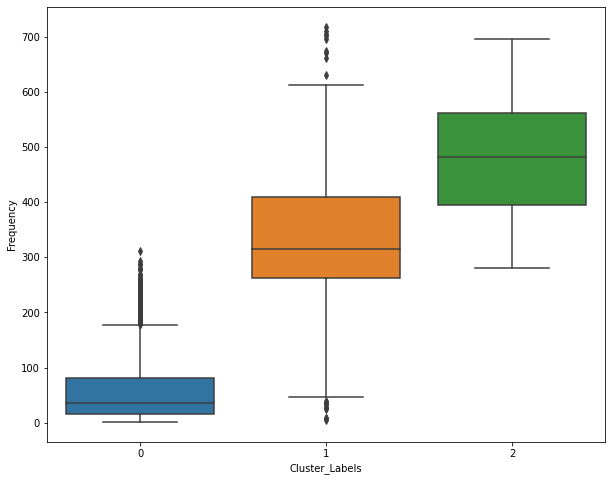

In [ ]:
# Plot Cluster Id vs Frequency

sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

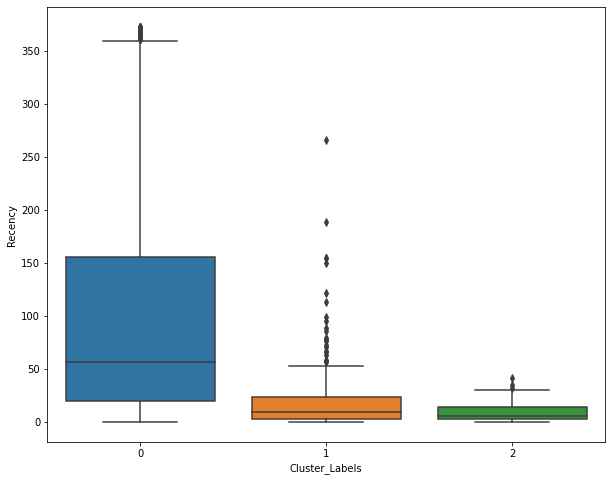

In [ ]:
# Plot Cluster Id vs Recency

sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

# Final Analysis

Hasil akhir yang ditemukan adalah

K-means clustering

1. Nasabah dengan Cluster Id 1 merupakan nasabah dengan jumlah transaksi yang tinggi dibandingkan dengan nasabah lainnya.

2. Pelanggan dengan Id Cluster 1 adalah pembeli tetap.

3. Pelanggan dengan Id Cluster 2 bukan pembeli baru-baru ini dan dalam posisi tidak terlalu penting di sudut pandang bisnis

Hiearcial Clustering 

1. Pelanggan dengan Cluster_Labels 2 adalah pelanggan dengan jumlah transaksi yang tinggi dibandingkan dengan pelanggan lain.

2. Pelanggan dengan Cluster_Labels 2 adalah pembeli tetap.

3. Pelanggan dengan Cluster_Labels 0 bukan pembeli baru-baru ini dan dalam posisi tidak terlalu penting di sudut pandang bisnis

Yang saya pelajari mengenai k-means dari coding diatas adalah k-means merupakan salah satu unsupervised learning dengan tujuan untuk melakukan pengelompokan data.

Dari contoh diatas, tahapan yang dilakukan adalah

1. mencari titik acak atau K points
2. mengkategorikan setiap item ke dalam mean terdekatnya dan update koordinat mean, yang merupakan rata-rata dari mean tiap item
3. pengulangan proses jumlah iterasi untuk mendapatkan cluster yang diperlukan

Namun sebelumnya kita bisa menggunakan metode elbow curves dalam mencari angka optimal untuk klusterisasi dan juga silhouette analysis

Perbedaan dari kedua metode ini adalah silhouette lebih memberikan hasil yang presisi untuk nilai dan k points sedangkan metode elbow sendiri memiliki respons yang cepat dan intuisi ketimbang dari silhouette.

Dan akhirnya pengelompokkan dapat ditetapkan sehingga dapat dilakukan analisis akhir terkait dari data yang diperlukan.
